In [1]:
import yaml
import os
import textwrap
import warnings

In [2]:
# Suppress LightGBM warnings
warnings.filterwarnings('ignore', message='.*lambda_l1 is set.*')
warnings.filterwarnings('ignore', message='.*lambda_l2 is set.*')
warnings.filterwarnings('ignore', category=UserWarning, module='lightgbm')

In [3]:
# Data wrangling
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import pearsonr

In [4]:
# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tqdm import tqdm

In [5]:
# Models
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [6]:
# Process control and optimization
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [7]:
# Models Pipelines
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

In [8]:
# Save model
import joblib

In [9]:
# Set style for better visualizations
plt.style.use('default')
sns.set_palette("husl")

In [10]:
# Load the configuration file
with open('../config.yaml', 'r') as config_file:
    config = yaml.safe_load(config_file)

# Access the settings
project_folder = config['projectFolder']
df_path = os.path.join(project_folder, config['transformedDataFile'])
df = pd.read_csv(df_path)

In [11]:
# Define features (X) and target variable (y)
X = df.drop('% Silica Concentrate', axis=1)  # Features (all columns except 'Job Offer')
y = df['% Silica Concentrate']  # Target variable

In [12]:
# Load saved model
model_path = '../model/final_model.pkl'  # Update with your actual path
final_model = joblib.load(model_path)

In [13]:
# Cell 2: Enhanced Data Loading and Initial Exploration
def load_and_explore_data(df):
    """Load data and perform comprehensive initial exploration"""
    
    print("=== FLOTATION PROCESS DATA ANALYSIS ===\n")
    
    # Basic info
    print(f"📊 Dataset Shape: {df.shape}")
    print(f"📅 Data Collection Period: {df.index.min()} to {df.index.max()}")
    
    # Process variables categorization
    input_variables = ['% Iron Feed', 'Starch Flow', 'Amina Flow', 'Ore Pulp Flow', 
                      'Ore Pulp pH', 'Ore Pulp Density']
    
    flotation_air_flows = [col for col in df.columns if 'Air Flow' in col]
    flotation_levels = [col for col in df.columns if 'Level' in col]
    
    output_variables = ['% Iron Concentrate', '% Silica Concentrate']
    
    print(f"🔧 Input Variables: {len(input_variables)}")
    print(f"💨 Flotation Air Flows: {len(flotation_air_flows)}")
    print(f"📏 Flotation Levels: {len(flotation_levels)}")
    print(f"🎯 Output Variables: {len(output_variables)}")
    
    # Data quality assessment
    print("\n=== DATA QUALITY ASSESSMENT ===")
    missing_data = df.isnull().sum()
    print(f"Missing values: {missing_data.sum()} total")
    
    if missing_data.sum() > 0:
        print("Variables with missing values:")
        print(missing_data[missing_data > 0])
    
    # Statistical summary
    print("\n=== KEY PERFORMANCE INDICATORS ===")
    for var in output_variables:
        if var in df.columns:
            print(f"{var}:")
            print(f"  Mean: {df[var].mean():.2f} ± {df[var].std():.2f}")
            print(f"  Range: [{df[var].min():.2f}, {df[var].max():.2f}]")
            print(f"  CV: {(df[var].std()/df[var].mean()*100):.1f}%")
    
    return df, input_variables, flotation_air_flows, flotation_levels, output_variables


In [14]:
# Process Performance Analysis
def analyze_process_performance(df, output_vars):
    import matplotlib.pyplot as plt
    
    available_outputs = [var for var in output_vars if var in df.columns]
    num_outputs = len(available_outputs)

    def calculate_cp(data, lsl, usl):
        return (usl - lsl) / (6 * data.std()) if data.std() != 0 else float('inf')
    
    fig, axes = plt.subplots(num_outputs, 2, figsize=(12, 4 * num_outputs))
    
    # Fix: Ensure axes is always a 2D array for consistent indexing
    if num_outputs == 1:
        axes = axes.reshape(1, 2)
    
    fig.suptitle('Process Performance Analysis', fontsize=16, fontweight='bold')
    
    for i, output_var in enumerate(available_outputs):
        # Use 2D indexing: axes[row, column]
        axes[i, 0].plot(df.index, df[output_var], alpha=0.7, color=['steelblue', 'orange'][i])
        mean = df[output_var].mean()
        axes[i, 0].axhline(y=mean, color='red', linestyle='--', 
                         label=f'Mean: {mean:.2f}')
        axes[i, 0].set_title(f'Time series of {output_var}')
        axes[i, 0].legend()

        axes[i, 1].hist(df[output_var], bins=30, color=['steelblue', 'orange'][i], alpha=0.7)
        axes[i, 1].set_title(f'Histogram of {output_var}')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    
    # Process capability analysis
    print("=== PROCESS CAPABILITY ANALYSIS ===")
    
    cp_values = {}
    for output_var in available_outputs:
        if 'Iron' in output_var:
            target = 66.5
            tolerance = 1.0
        else:
            target = 1.5
            tolerance = 0.5
        
        cp = calculate_cp(df[output_var], target - tolerance, target + tolerance)
        cp_values[output_var] = cp
        print(f"{output_var} Cp: {cp:.3f}")
    
    return cp_values

In [15]:
# Critical Process Variable Analysis
def analyze_critical_variables(df, input_vars, air_flows, levels, output_vars):
    """Identify and analyze critical process variables"""
    
    all_process_vars = input_vars + air_flows + levels
    available_process_vars = [var for var in all_process_vars if var in df.columns]
    available_output_vars = [var for var in output_vars if var in df.columns]
    
    if not available_output_vars:
        print("No output variables available for analysis")
        return {}, {}
    
    # Calculate correlations with output variables
    correlations = {}
    for output_var in available_output_vars:
        correlations[output_var] = {}
        for process_var in available_process_vars:
            try:
                var1 = df[process_var].dropna()
                var2 = df[output_var].dropna()
                
                common_idx = var1.index.intersection(var2.index)
                if len(common_idx) > 10:
                    corr, p_value = pearsonr(df.loc[common_idx, process_var], 
                                           df.loc[common_idx, output_var])
                    correlations[output_var][process_var] = {
                        'correlation': corr, 
                        'p_value': p_value
                    }
            except Exception as e:
                print(f"Error calculating correlation for {process_var}: {e}")
                continue
    
    # Create correlation visualization
    n_outputs = len(available_output_vars)
    fig, axes = plt.subplots(1, n_outputs, figsize=(10*n_outputs, 8))
    
    if n_outputs == 1:
        axes = [axes]
    
    for idx, output_var in enumerate(available_output_vars):
        if output_var in correlations and correlations[output_var]:
            corr_data = {var: correlations[output_var][var]['correlation'] 
                        for var in correlations[output_var]}
            
            # Sort by absolute correlation
            sorted_corr = dict(sorted(corr_data.items(), 
                                    key=lambda x: abs(x[1]), reverse=True))
            
            # Plot top 10 correlations
            top_vars = list(sorted_corr.keys())[:10]
            top_corr = [sorted_corr[var] for var in top_vars]
            
            colors = ['red' if x < 0 else 'steelblue' for x in top_corr]
            
            axes[idx].barh(range(len(top_vars)), top_corr, color=colors, alpha=0.7)
            axes[idx].set_yticks(range(len(top_vars)))
            axes[idx].set_yticklabels([var.replace('Flotation Column ', 'FC') 
                                     for var in top_vars])
            axes[idx].set_xlabel('Correlation Coefficient')
            axes[idx].set_title(f'Top Process Variables Correlated with {output_var}')
            axes[idx].grid(True, alpha=0.3)
            axes[idx].axvline(x=0, color='black', linestyle='-', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Identify critical variables
    critical_vars = {}
    for output_var in available_output_vars:
        critical_vars[output_var] = []
        if output_var in correlations:
            for var, stats in correlations[output_var].items():
                if abs(stats['correlation']) > 0.3 and stats['p_value'] < 0.05:
                    critical_vars[output_var].append({
                        'variable': var,
                        'correlation': stats['correlation'],
                        'p_value': stats['p_value']
                    })
        
        critical_vars[output_var].sort(key=lambda x: abs(x['correlation']), reverse=True)
    
    print("=== CRITICAL PROCESS VARIABLES ===")
    for output_var in available_output_vars:
        print(f"\n{output_var}:")
        if critical_vars[output_var]:
            for var_info in critical_vars[output_var][:5]:
                print(f"  {var_info['variable']}: r={var_info['correlation']:.3f}, "
                      f"p={var_info['p_value']:.3e}")
        else:
            print("  No significant correlations found")
    
    return critical_vars, correlations


In [16]:
# Process Optimization Analysis
def analyze_process_optimization(df, output_vars):
    """Perform process optimization analysis"""
    
    available_outputs = [col for col in output_vars if col in df.columns]
    optimization_results = {}
    
    print("\n=== PROCESS OPTIMIZATION ANALYSIS ===")
    
    for output_var in available_outputs:
        print(f"\nOptimization for {output_var}:")
        
        # Define optimization criteria
        if 'Iron' in output_var:
            # Higher iron concentrate is better
            threshold = df[output_var].quantile(0.75)
            high_perf = df[output_var] >= threshold
            direction = "maximize"
            print(f"  High Performance: {output_var} ≥ {threshold:.2f}")
        else:
            # Lower silica concentrate is better
            threshold = df[output_var].quantile(0.25)
            high_perf = df[output_var] <= threshold
            direction = "minimize"
            print(f"  High Performance: {output_var} ≤ {threshold:.2f}")
        
        high_perf_count = high_perf.sum()
        high_perf_pct = (high_perf_count / len(df)) * 100
        
        print(f"  High Performance Samples: {high_perf_count} ({high_perf_pct:.1f}%)")
        
        optimization_results[output_var] = {
            'threshold': threshold,
            'direction': direction,
            'high_performance_samples': high_perf_count,
            'high_performance_percentage': high_perf_pct,
            'high_performance_mask': high_perf
        }
    
    return optimization_results

In [17]:
def analyze_process_variability(df, output_vars):
    """Analyze sources of process variability"""
    
    variability_analysis = {}
    
    print("\n=== PROCESS VARIABILITY ANALYSIS ===")
    
    for output_var in output_vars:
        if output_var not in df.columns:
            continue
            
        data = df[output_var].values
        
        # Time-based variability
        rolling_std = pd.Series(data).rolling(window=50).std()
        
        # Identify high variability periods
        high_var_threshold = rolling_std.quantile(0.9)
        high_var_periods = rolling_std > high_var_threshold
        
        # Calculate variability metrics
        total_variance = np.var(data)
        within_subgroup_variance = np.mean([np.var(data[i:i+10]) for i in range(0, len(data)-10, 10)])
        between_subgroup_variance = total_variance - within_subgroup_variance
        
        variability_analysis[output_var] = {
            'total_variance': total_variance,
            'within_variance': within_subgroup_variance,
            'between_variance': between_subgroup_variance,
            'variance_ratio': between_subgroup_variance / within_subgroup_variance if within_subgroup_variance > 0 else 0,
            'high_variability_periods': high_var_periods.sum()
        }
        
        print(f"\n{output_var} Variability Analysis:")
        print(f"  Total Variance: {total_variance:.4f}")
        print(f"  Within-batch Variance: {within_subgroup_variance:.4f}")
        print(f"  Between-batch Variance: {between_subgroup_variance:.4f}")
        print(f"  Variance Ratio: {variability_analysis[output_var]['variance_ratio']:.2f}")
    
    return variability_analysis

In [18]:
def analyze_process_stability(df, output_vars):
    """Analyze process stability over time"""
    
    stability_results = []
    
    print("\n=== PROCESS STABILITY ANALYSIS ===")
    
    for output_var in output_vars:
        if output_var not in df.columns:
            continue
            
        # Split data into first and second half
        mid_point = len(df) // 2
        first_half = df[output_var].iloc[:mid_point]
        second_half = df[output_var].iloc[mid_point:]
        
        mean_diff = second_half.mean() - first_half.mean()
        std_diff = second_half.std() - first_half.std()
        
        print(f"\n{output_var} Stability Analysis:")
        
        if abs(mean_diff) > first_half.std() * 0.1:
            trend = "increasing" if mean_diff > 0 else "decreasing"
            stability_results.append(f"{output_var} shows {trend} trend (Δ mean: {mean_diff:.3f})")
            print(f"  Mean Trend: {trend} (Change: {mean_diff:.3f})")
        else:
            stability_results.append(f"{output_var} appears stable over time")
            print(f"  Mean Trend: Stable")
        
        if abs(std_diff) > first_half.std() * 0.1:
            var_trend = "increasing" if std_diff > 0 else "decreasing"
            stability_results.append(f"{output_var} variability is {var_trend} (Δ std: {std_diff:.3f})")
            print(f"  Variability Trend: {var_trend} (Change: {std_diff:.3f})")
        else:
            print(f"  Variability Trend: Stable")
    
    return stability_results


In [19]:
def create_control_charts(df, output_vars):
    """Create statistical process control charts"""
    
    available_outputs = [col for col in output_vars if col in df.columns]
    
    if not available_outputs:
        print("No output variables available for control charts")
        return
    
    fig, axes = plt.subplots(len(available_outputs), 2, figsize=(15, 8*len(available_outputs)))
    
    if len(available_outputs) == 1:
        axes = axes.reshape(1, -1)
    
    for idx, var in enumerate(available_outputs):
        data = df[var].values
        
        # Individual values chart
        axes[idx, 0].plot(data, 'b-', alpha=0.7)
        mean = np.mean(data)
        std = np.std(data)
        
        # Control limits (3-sigma)
        ucl = mean + 3*std
        lcl = mean - 3*std
        
        axes[idx, 0].axhline(y=mean, color='g', linestyle='-', label=f'Mean: {mean:.2f}')
        axes[idx, 0].axhline(y=ucl, color='r', linestyle='--', label=f'UCL: {ucl:.2f}')
        axes[idx, 0].axhline(y=lcl, color='r', linestyle='--', label=f'LCL: {lcl:.2f}')
        
        # Moving range chart
        moving_range = np.abs(np.diff(data))
        mr_mean = np.mean(moving_range)
        mr_ucl = 3.268 * mr_mean  # D4 constant for n=2
        
        axes[idx, 1].plot(moving_range, 'b-', alpha=0.7)
        axes[idx, 1].axhline(y=mr_mean, color='g', linestyle='-', label=f'MR Mean: {mr_mean:.2f}')
        axes[idx, 1].axhline(y=mr_ucl, color='r', linestyle='--', label=f'MR UCL: {mr_ucl:.2f}')
        
        axes[idx, 0].set_title(f'{var} - Individual Values Chart')
        axes[idx, 1].set_title(f'{var} - Moving Range Chart')
        axes[idx, 0].legend()
        axes[idx, 1].legend()
        axes[idx, 0].grid(True, alpha=0.3)
        axes[idx, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [20]:
def model_based_optimization(final_model, X, output_var):
    """Use the trained model to find optimal operating conditions"""
    
    feature_names = X.columns.tolist()
    
    # Create optimization scenarios
    scenarios = []
    
    # Baseline scenario (median values)
    baseline = X.median().values
    scenarios.append(('Baseline', baseline))
    
    # Optimized scenarios - vary key parameters
    for i in range(min(5, len(feature_names))):
        optimized = baseline.copy()
        
        # For silica concentrate - decrease (since lower is better)
        optimized[i] = X.iloc[:, i].quantile(0.25)  # 25th percentile
        scenarios.append((f'Optimize {feature_names[i]}', optimized))
    
    # Predict outcomes for each scenario
    results = []
    for scenario_name, conditions in scenarios:
        prediction = final_model.predict([conditions])[0]
        results.append({
            'scenario': scenario_name,
            'conditions': conditions,
            'predicted_output': prediction
        })
    
    # Sort by predicted output (lower is better for silica)
    results.sort(key=lambda x: x['predicted_output'])
    
    print(f"\n=== MODEL-BASED OPTIMIZATION FOR {output_var} ===")
    for i, result in enumerate(results[:3]):
        print(f"\nScenario {i+1}: {result['scenario']}")
        print(f"Predicted {output_var}: {result['predicted_output']:.2f}")
        
        # Show key parameter changes from baseline
        if i > 0:
            baseline_conditions = results[0]['conditions']
            for j, (param, value) in enumerate(zip(feature_names, result['conditions'])):
                if abs(value - baseline_conditions[j]) > 0.01:
                    change = ((value - baseline_conditions[j]) / baseline_conditions[j]) * 100
                    print(f"  {param}: {value:.2f} ({change:+.1f}%)")
    
    return results


In [21]:
def create_process_monitoring_dashboard(df, output_vars):
    """Create a comprehensive process monitoring dashboard"""
    
    available_outputs = [col for col in output_vars if col in df.columns]
    
    if not available_outputs:
        print("No output variables available for monitoring dashboard")
        return {}, []
    
    # Key Performance Indicators
    kpis = {}
    for var in available_outputs:
        current_value = df[var].iloc[-1]
        target_value = df[var].mean()
        spec_limit = df[var].std() * 2
        
        kpis[var] = {
            'current': current_value,
            'target': target_value,
            'deviation': abs(current_value - target_value),
            'in_spec': abs(current_value - target_value) <= spec_limit,
            'trend': 'stable'
        }
    
    # Alarm conditions
    alarms = []
    for var, kpi in kpis.items():
        if not kpi['in_spec']:
            alarms.append({
                'variable': var,
                'type': 'Out of Specification',
                'severity': 'High' if kpi['deviation'] > df[var].std() * 3 else 'Medium',
                'value': kpi['current'],
                'target': kpi['target']
            })
    
    print("\n=== PROCESS MONITORING DASHBOARD ===")
    print(f"\nKPI Status:")
    for var, kpi in kpis.items():
        status = "✓ IN SPEC" if kpi['in_spec'] else "✗ OUT OF SPEC"
        print(f"  {var}: {kpi['current']:.2f} (Target: {kpi['target']:.2f}) {status}")
    
    if alarms:
        print(f"\nActive Alarms ({len(alarms)}):")
        for alarm in alarms:
            print(f"  {alarm['severity']}: {alarm['variable']} - {alarm['type']}")
    else:
        print("\n✓ No Active Alarms")
    
    return kpis, alarms


In [22]:
def generate_process_improvement_recommendations(critical_vars, optimization_results, variability_analysis, df):
    """Generate actionable process improvement recommendations"""
    
    recommendations = []
    
    print("\n=== PROCESS IMPROVEMENT RECOMMENDATIONS ===")
    
    # Based on critical variables
    for output_var, vars_list in critical_vars.items():
        if vars_list:
            for var_info in vars_list[:3]:  # Top 3 critical variables
                var_name = var_info['variable']
                correlation = var_info['correlation']
                
                if 'Iron' in output_var:
                    if correlation > 0:
                        action = f"Increase {var_name} to improve iron recovery"
                    else:
                        action = f"Decrease {var_name} to improve iron recovery"
                else:  # Silica
                    if correlation > 0:
                        action = f"Decrease {var_name} to reduce silica content"
                    else:
                        action = f"Increase {var_name} to reduce silica content"
                
                recommendations.append({
                    'priority': 'High',
                    'action': action,
                    'variable': var_name,
                    'correlation': correlation,
                    'confidence': 'High'
                })
    
    # Based on variability analysis
    for output_var, var_data in variability_analysis.items():
        if var_data['variance_ratio'] > 2.0:
            recommendations.append({
                'priority': 'Medium',
                'action': f"Reduce process variability for {output_var}",
                'variable': output_var,
                'current_ratio': var_data['variance_ratio'],
                'confidence': 'Medium'
            })
    
    # Based on optimization results
    for output_var, opt_data in optimization_results.items():
        if opt_data['high_performance_percentage'] < 30:
            recommendations.append({
                'priority': 'High',
                'action': f"Implement control strategies to increase {output_var} performance",
                'variable': output_var,
                'current_performance': opt_data['high_performance_percentage'],
                'confidence': 'High'
            })
    
    # General recommendations
    recommendations.extend([
        {
            'priority': 'Medium',
            'action': 'Implement Statistical Process Control (SPC) charts',
            'variable': 'All outputs',
            'confidence': 'High'
        },
        {
            'priority': 'Medium',
            'action': 'Establish real-time monitoring system',
            'variable': 'Critical variables',
            'confidence': 'High'
        },
        {
            'priority': 'Low',
            'action': 'Conduct designed experiments for process optimization',
            'variable': 'Process conditions',
            'confidence': 'Medium'
        }
    ])
    
    # Sort by priority
    priority_order = {'High': 1, 'Medium': 2, 'Low': 3}
    recommendations.sort(key=lambda x: priority_order.get(x['priority'], 4))
    
    # Display recommendations
    for i, rec in enumerate(recommendations[:10], 1):  # Top 10
        print(f"\n{i}. [{rec['priority']} Priority] {rec['action']}")
        if 'correlation' in rec:
            print(f"   Based on correlation: {rec['correlation']:.3f}")
        if 'current_ratio' in rec:
            print(f"   Current variance ratio: {rec['current_ratio']:.2f}")
        if 'current_performance' in rec:
            print(f"   Current performance: {rec['current_performance']:.1f}%")
        print(f"   Confidence: {rec['confidence']}")
    
    return recommendations


Starting Process Improvement Analysis...
=== FLOTATION PROCESS DATA ANALYSIS ===

📊 Dataset Shape: (3925, 21)
📅 Data Collection Period: 0 to 3924
🔧 Input Variables: 6
💨 Flotation Air Flows: 6
📏 Flotation Levels: 7
🎯 Output Variables: 2

=== DATA QUALITY ASSESSMENT ===
Missing values: 0 total

=== KEY PERFORMANCE INDICATORS ===
% Iron Concentrate:
  Mean: 65.04 ± 1.12
  Range: [62.05, 68.01]
  CV: 1.7%
% Silica Concentrate:
  Mean: 2.33 ± 1.13
  Range: [0.60, 5.53]
  CV: 48.4%



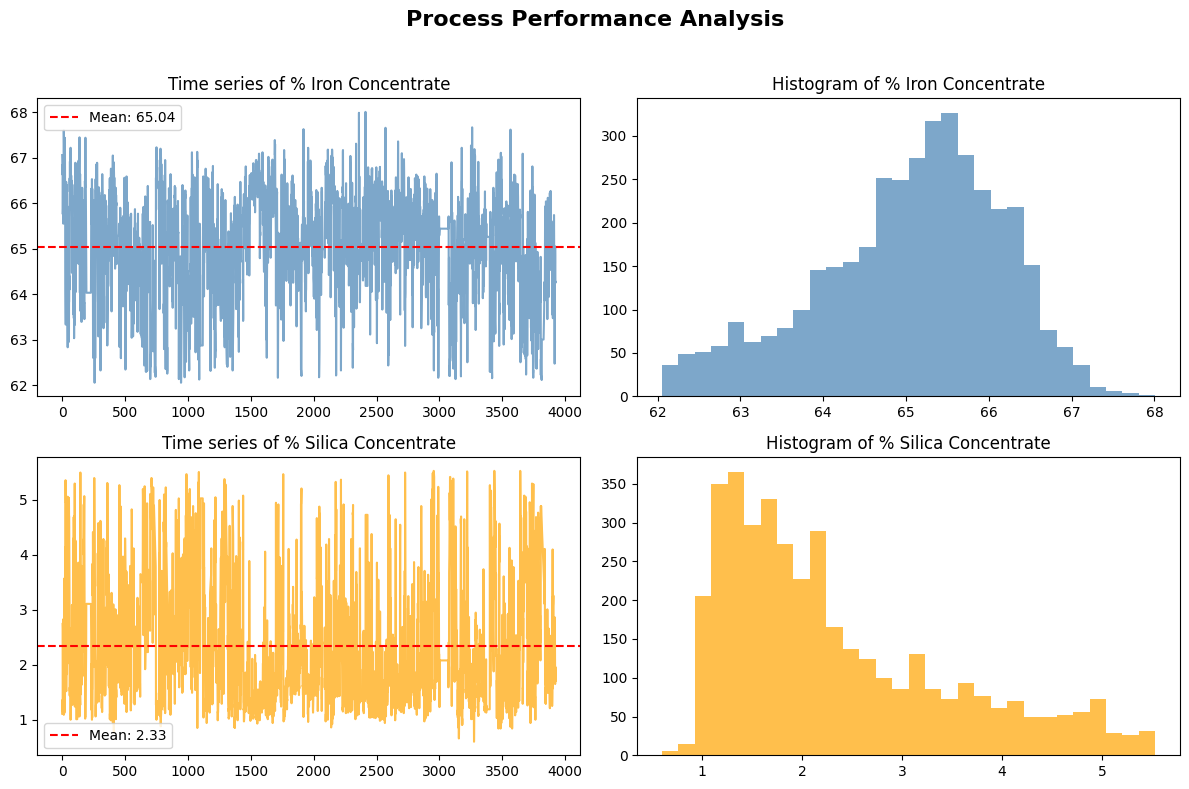

=== PROCESS CAPABILITY ANALYSIS ===
% Iron Concentrate Cp: 0.298
% Silica Concentrate Cp: 0.148



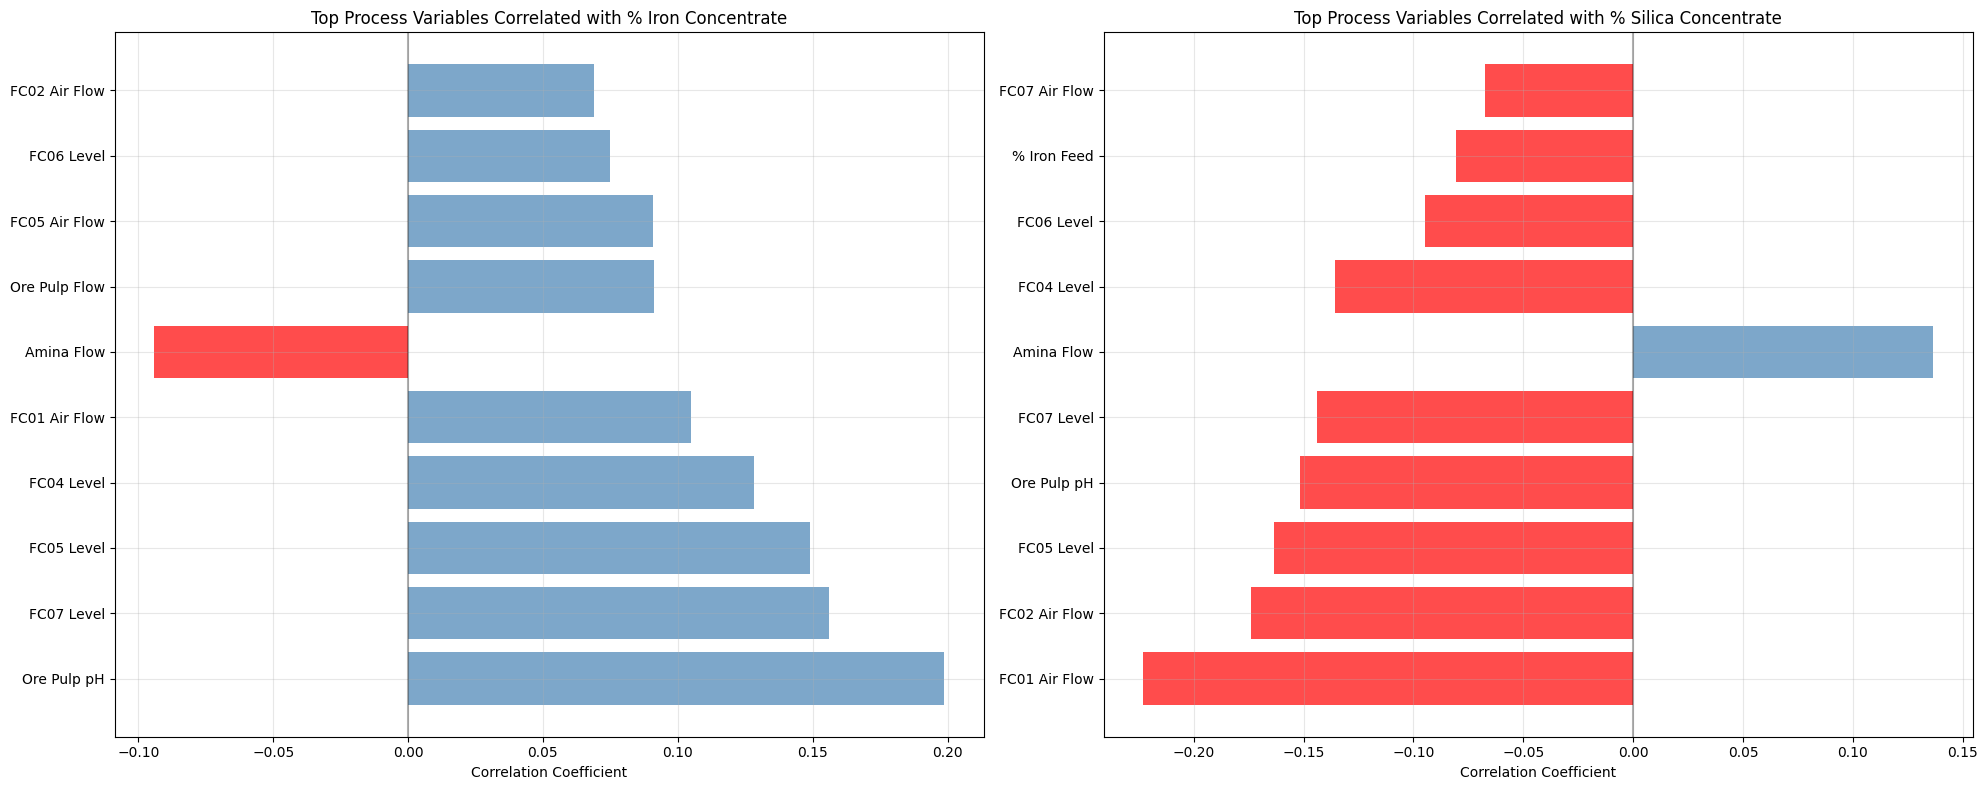

=== CRITICAL PROCESS VARIABLES ===

% Iron Concentrate:
  No significant correlations found

% Silica Concentrate:
  No significant correlations found


=== PROCESS OPTIMIZATION ANALYSIS ===

Optimization for % Iron Concentrate:
  High Performance: % Iron Concentrate ≥ 65.85
  High Performance Samples: 994 (25.3%)

Optimization for % Silica Concentrate:
  High Performance: % Silica Concentrate ≤ 1.44
  High Performance Samples: 984 (25.1%)


=== PROCESS VARIABILITY ANALYSIS ===

% Iron Concentrate Variability Analysis:
  Total Variance: 1.2545
  Within-batch Variance: 0.5272
  Between-batch Variance: 0.7273
  Variance Ratio: 1.38

% Silica Concentrate Variability Analysis:
  Total Variance: 1.2761
  Within-batch Variance: 0.4975
  Between-batch Variance: 0.7786
  Variance Ratio: 1.57


=== PROCESS STABILITY ANALYSIS ===

% Iron Concentrate Stability Analysis:
  Mean Trend: Stable
  Variability Trend: decreasing (Change: -0.119)

% Silica Concentrate Stability Analysis:
  Mean Trend: de

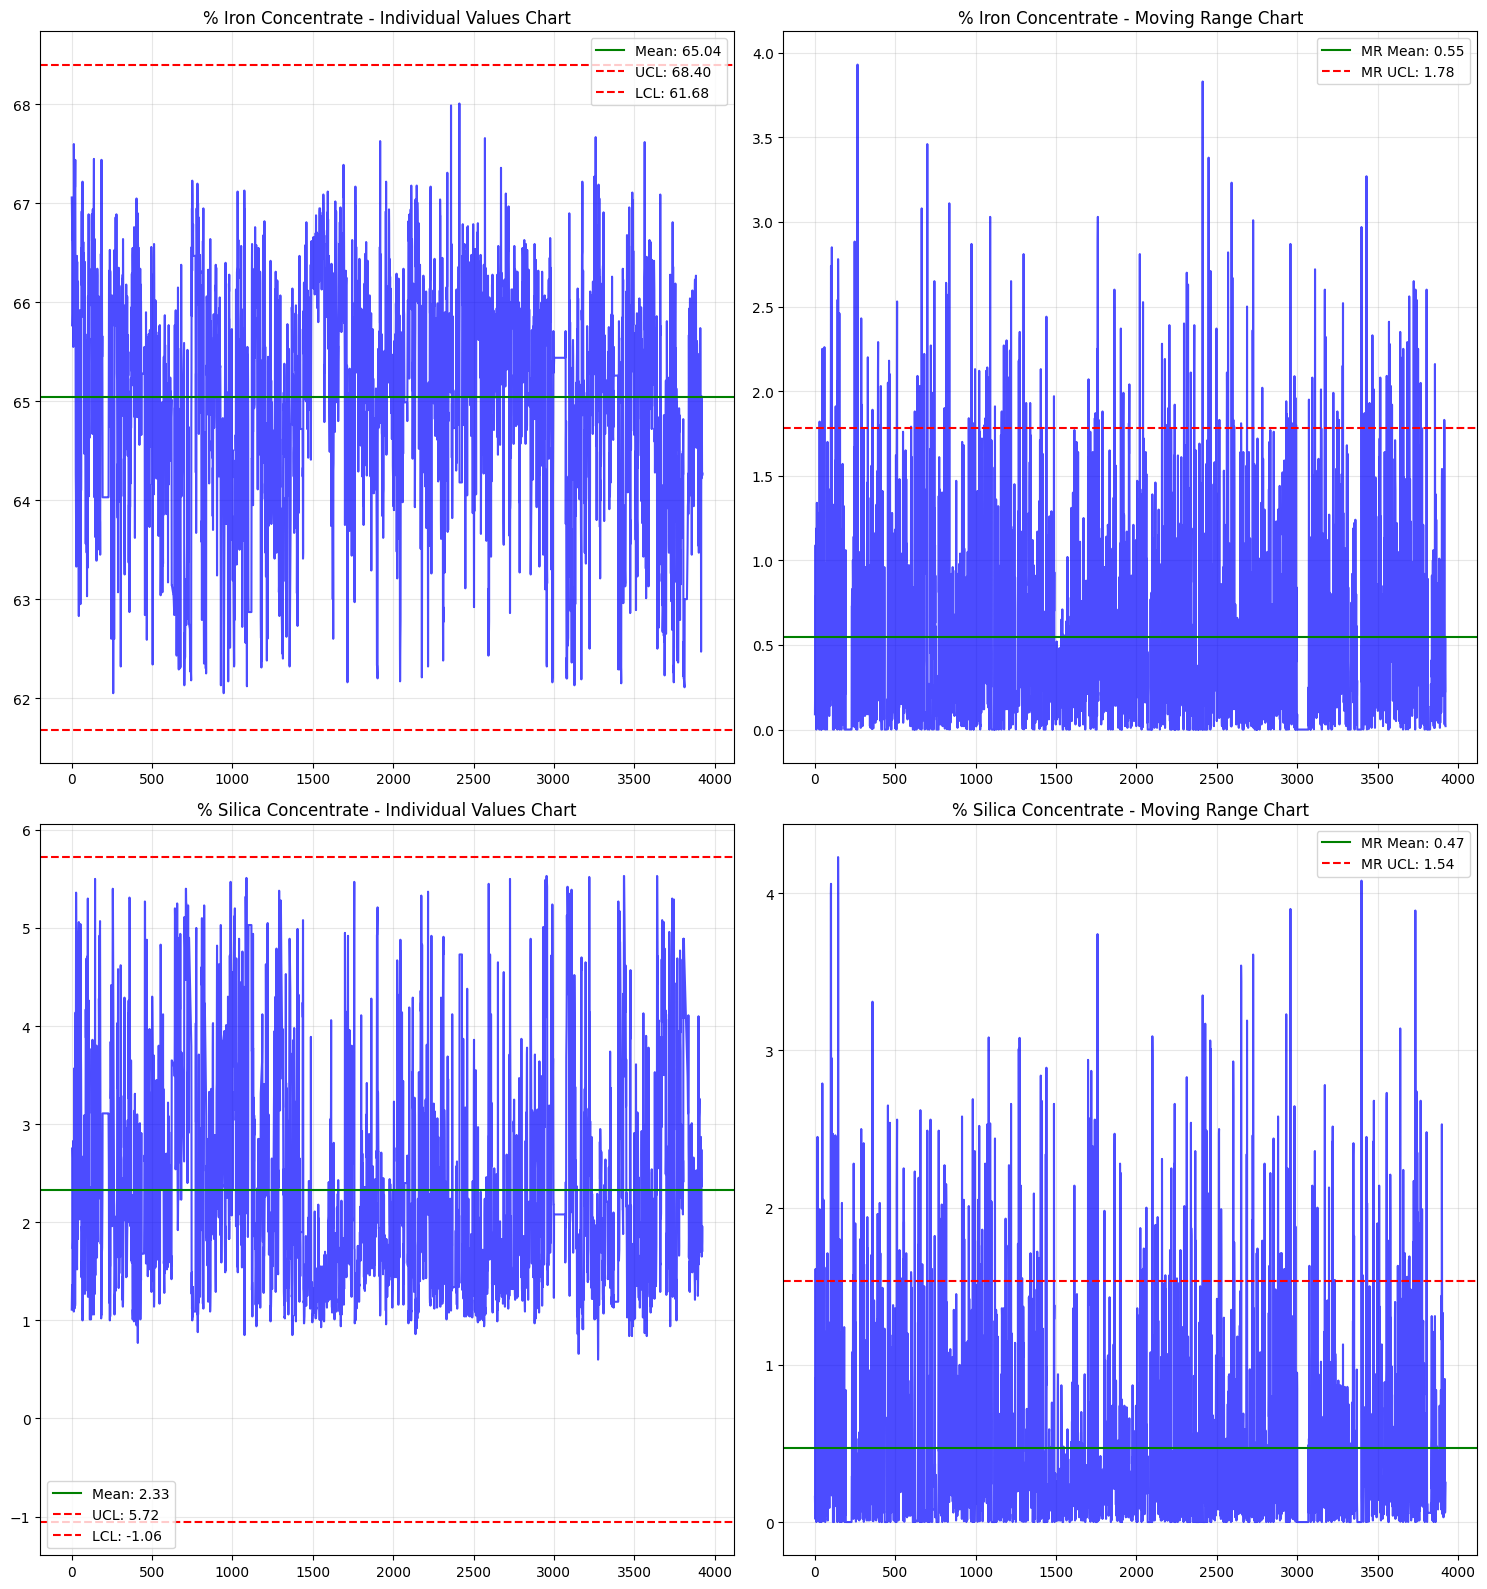

c:\Users\mjkipsz2\AppData\Local\pypoetry\Cache\virtualenvs\mining-dataset-training-F8FwK34a-py3.12\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] lambda_l1 is set=0.9364334886334374, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9364334886334374
[LightGBM] [Warning] lambda_l2 is set=2.406570084459572, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.406570084459572
[LightGBM] [Warning] lambda_l1 is set=0.9364334886334374, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9364334886334374
[LightGBM] [Warning] lambda_l2 is set=2.406570084459572, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.406570084459572
[LightGBM] [Warning] lambda_l1 is set=0.9364334886334374, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9364334886334374
[LightGBM] [Warning] lambda_l2 is set=2.406570084459572, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.406570084459572
[LightGBM] [Warning] lambda_l1 is set=0.9364334886334374, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9364334886334374
[LightGBM] [Warning] lambda_l2 is set=2.406570084459572, reg_lambda=0.0 

c:\Users\mjkipsz2\AppData\Local\pypoetry\Cache\virtualenvs\mining-dataset-training-F8FwK34a-py3.12\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\mjkipsz2\AppData\Local\pypoetry\Cache\virtualenvs\mining-dataset-training-F8FwK34a-py3.12\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\mjkipsz2\AppData\Local\pypoetry\Cache\virtualenvs\mining-dataset-training-F8FwK34a-py3.12\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\mjkipsz2\AppData\Local\pypoetry\Cache\virtualenvs\mining-dataset-training-F8FwK34a-py3.12\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, b

In [23]:
# MAIN EXECUTION - RUN ALL FUNCTIONS
# ========================================================================================

print("Starting Process Improvement Analysis...")
print("="*50)

# Function 1: Load and explore data
df, input_vars, air_flows, levels, output_vars = load_and_explore_data(df)
print("\n" + "="*50)

# Function 2: Analyze process performance
cp_values = analyze_process_performance(df, output_vars)
print("\n" + "="*50)

# Function 3: Analyze critical variables
critical_vars, correlations = analyze_critical_variables(df, input_vars, air_flows, levels, output_vars)
print("\n" + "="*50)

# Function 4: Process optimization analysis
optimization_results = analyze_process_optimization(df, output_vars)
print("\n" + "="*50)

# Function 5: Process variability analysis
variability_analysis = analyze_process_variability(df, output_vars)
print("\n" + "="*50)

# Function 6: Process stability analysis
stability_results = analyze_process_stability(df, output_vars)
print("\n" + "="*50)

# Function 7: Create control charts
print("\n=== STATISTICAL PROCESS CONTROL CHARTS ===")
create_control_charts(df, output_vars)
print("\n" + "="*50)

# Function 8: Model-based optimization
model_optimization_results = model_based_optimization(final_model, X, '% Silica Concentrate')
print("\n" + "="*50)

# Function 9: Process monitoring dashboard
kpis, alarms = create_process_monitoring_dashboard(df, output_vars)
print("\n" + "="*50)

# Function 10: Generate recommendations
recommendations = generate_process_improvement_recommendations(
    critical_vars, optimization_results, variability_analysis, df
)

print("\n" + "="*50)
print("PROCESS IMPROVEMENT ANALYSIS COMPLETE")
print("="*50)

# Summary Statistics
print(f"\n=== SUMMARY STATISTICS ===")
print(f"Total samples analyzed: {len(df)}")
print(f"Process variables analyzed: {len(input_vars) + len(air_flows) + len(levels)}")
print(f"Output variables: {len(output_vars)}")
print(f"Critical variables identified: {sum(len(vars_list) for vars_list in critical_vars.values())}")
print(f"Recommendations generated: {len(recommendations)}")
print(f"Active alarms: {len(alarms)}")